# [SKT Market Top AI]Transformer‑based Multivariate Time Series Anomaly Detection using Inter‑Variable Attention Mechanism

## 요약

- 변수 간의 시간적 종속성과 관계를 명시적으로 캡처하는 다변량 시계열 이상 탐지 방법인 `Variable Temporal Transformer`를 제안

- 시간 종속성을 학습하는 Temporal self-attention과 변수 간 상관관계를 명시적으로 캡처하기 위해 기존의 Temporal self-attention을 수정하여 새로 제안된 `Variable self-attention`을 도입

- 4개의 공개 benchmark 데이터셋에 대해 VTT가 baseline보다 개선된 성능을 보임

- 원본 데이터에서 추출한 attention map과 재구성된 데이터에서 추출한 attention map을 비교하여 이상치 발생 원인을 추정하는 프로세스를 제안

<img src="../image/VTT_architecture.png" width="600">

[Kang, Hyeongwon, and Pilsung Kang. "Transformer-based multivariate time series anomaly detection using inter-variable attention mechanism." Knowledge-Based Systems (2024): 111507.](https://www.sciencedirect.com/science/article/pii/S0950705124001424?ref=pdf_download&fr=RR-2&rr=88e52cc379d63158)

### SETP 0. 환경 구축하기

---

- VTT 모델에 맞는 환경을 구축하기 위하여 필요한 패키지를 설치합니다.

In [1]:
# github에서 데이터 불러오기
# !git clone https://github.com/hwk0702/KBS2024-VTT.git
# %cd ./KBS2024-VTT/src
%cd ../src

# !pip install -r ../requirements.txt

/tf/dsba/personal_project/KBS2024-VTT/src


- 필요한 library들을 import 합니다.

In [2]:
import os  # 운영 체제와의 상호작용을 위한 모듈
import sys  # 시스템 특정 파라미터와 함수를 위한 모듈
import random  # 난수 생성기를 위한 모듈
import math  # 수학적 함수와 상수를 위한 모듈
import time  # 시간 관련 함수를 위한 모듈
import json  # JSON 데이터 파싱과 생성을 위한 모듈
import yaml  # YAML 파일 파싱과 생성을 위한 모듈
import warnings  # 경고 메시지를 관리하기 위한 모듈
warnings.filterwarnings("ignore")  # 경고 메시지를 무시하도록 설정

import argparse  # 명령행 옵션, 인자 파싱 모듈
from datetime import datetime  # 날짜와 시간 관련 모듈

import numpy as np # 다차원 배열과 연산을 다루는 모듈
import pandas as pd  # 데이터 조작 및 분석을 위한 라이브러리
from sklearn.preprocessing import MinMaxScaler, StandardScaler  # 데이터 전처리를 위한 스케일링 모듈

import matplotlib.pyplot as plt  # 데이터 시각화를 위한 라이브러리
%matplotlib inline  # 주피터 노트북에서 인라인으로 그래프를 표시

from easydict import EasyDict  # 딕셔너리의 속성을 점 표기법으로 접근할 수 있도록 하는 모듈
from omegaconf import OmegaConf  # 설정 파일 관리를 위한 모듈

import torch  # 딥러닝을 위한 라이브러리
from torch import optim, einsum  # 최적화 및 다차원 배열 연산을 위한 모듈
import torch.nn as nn  # 신경망 구축을 위한 모듈
from torch.utils.data import Dataset  # 데이터셋 구성을 위한 모듈
from torch.nn.utils import weight_norm  # 신경망 가중치 정규화를 위한 모듈

from einops import rearrange, repeat  # 배열 재구성 및 반복을 위한 모듈

from layers.Transformer_Enc import PreNorm, FeedForward  # 사용자 정의 트랜스포머 인코더 모듈

from utils.utils import set_seed, log_setting, version_build  # 유틸리티 함수들
from utils.tools import EarlyStopping, adjust_learning_rate, check_graph  # 학습 조기 종료 및 학습률 조정 도구
from data_provider.dataloader import get_dataloader  # 데이터 로더 함수
from model import build_model  # 모델 빌드 함수

# torch 버전 및 디바이스를 확인
print("Python version:[%s]." % (sys.version))
print("PyTorch version:[%s]." % (torch.__version__))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("device:[%s]." % (device))  # GPU를 사용 가능한 경우 'cuda:0'가 출력되면 GPU를 사용

Python version:[3.6.9 (default, Dec  8 2021, 21:08:43) 
[GCC 8.4.0]].
PyTorch version:[1.7.1].
device:[cuda:0].


모델에 필요한 argument들을 설정합니다.

In [3]:
# 설정 인자들을 정의
args = EasyDict({
    # for dataloader 
    'dataname': 'SWaT',
    'subdataname': None,
    'window_size': 100,
    'slide_size': 100,

    # for training
    'train': True,
    'test': True,
    'resume': None,
    'model': 'VTTPAT',
    'epochs': 20,
    'patience': 5,

    # for loss
    'loss': 'mse',

    # for setting
    'seed': 72,
    'use_gpu':True,
    'gpu': 0,
    'use_multi_gpu': False,
    'devices': '0',
    'configure': './config.yaml',
    'batch_size': 16
})

# 구성 파일을 로드합니다.
with open(args.configure) as f:
    config = OmegaConf.load(f)

# 로드된 구성 내용을 출력합니다.
print(OmegaConf.to_yaml(config, resolve=True))

In [5]:
# 로그 디렉토리와 저장 디렉토리를 설정
logdir = os.path.join(config.log_dir, f'{args.dataname}/{args.model}')
savedir = version_build(logdir=logdir, is_train=args.train, resume=args.resume)

# GPU 사용 설정을 구성
if args.use_gpu and args.use_multi_gpu:
    # GPU 디바이스 목록을 설정
    args.devices = args.devices.replace(' ', '')
    args.device_ids = list(map(int, args.devices.split(',')))
    args.gpu = args.device_ids[0]  # 첫 번째 GPU를 기본 GPU로 설정

# 랜덤 시드를 설정
set_seed(args.seed)

# 모델 파라미터를 설정
model_params = config[args.model]

# 모델 파라미터를 수정(실험 세팅 가볍게)
model_params.n_layer = 1
model_params.n_head = 2

### SETP 1. 데이터 준비하기 (이 부분만 데이터를 포맷에 맞게 코드 변경 해주시면 됩니다!)

SWaT 데이터를 활용하여 시계열 이상탐지를 진행합니다.
* 스마트 물 처리 공장 내의 센서 및 액추에이터 데이터로, 펌프와 밸브 등의 작동 상태를 바탕으로 추출된 물의 흐름, 압력, 수위 등 다양한 물리적 변수 포함
* 11일 간 51개 센서에서 수집된 데이터셋이며, 다양한 사이버 공격 시나리오가 포함됨. 이상치는 전체 11일 기간 중 마지막 4일에서 총 41회 발생
* 데이터 크기 및 유형: 11일간의 연속 데이터, 946,722개의 데이터 포인트, 이상 비율 11.98%
* 데이터셋 출처
    * https://itrust.sutd.edu.sg/itrust-labs_datasets/dataset_info/

train 데이터셋의 일부를 validation 데이터셋으로 나눕니다.

In [ ]:
# !pip install gdown
import gdown

train_url = 'https://drive.google.com/uc?id=1IYPnLUjaHMzwefzmxErQpb9UYGW_1dpQ'
train_file = './SWaT_Dataset_Normal_v1.pkl'  
gdown.download(train_url, train_file, quiet=False)

test_url = 'https://drive.google.com/uc?id=17TUUeUgCgEmPoR372yvg41iuOQzAKtUU'
test_file = './SWaT_Dataset_Attack_v0.pkl'  
gdown.download(test_url, test_file, quiet=False)

In [7]:
# 파일 경로 설정
train_path = '../data/SWaT/SWaT.A1 _ A2_Dec 2015/Physical/SWaT_Dataset_Normal_v1.pkl'
test_path = '../data/SWaT/SWaT.A1 _ A2_Dec 2015/Physical/SWaT_Dataset_Attack_v0.pkl'

# 검증 데이터 분할 비율
valid_split_rate = 0.8

# 훈련 데이터셋 로드 및 전처리
trainset = pd.read_pickle(train_path).drop(['Normal/Attack', ' Timestamp'], axis=1)
valid_split_index = int(len(trainset) * valid_split_rate)
validset = trainset.iloc[valid_split_index:].to_numpy()  # 검증 데이터셋
trainset = trainset.iloc[:valid_split_index].to_numpy()  # 훈련 데이터셋
train_timestamp = np.arange(len(trainset))  # 훈련 데이터 타임스탬프
valid_timestamp = np.arange(len(validset))  # 검증 데이터 타임스탬프

# 테스트 데이터셋 로드 및 전처리
testset = pd.read_pickle(test_path)
test_timestamp = np.arange(len(testset))  # 테스트 데이터 타임스탬프
test_label = testset['Normal/Attack'].copy()
test_label[test_label == 'Normal'] = 0
test_label[test_label != 0] = 1
testset = testset.drop(['Normal/Attack', ' Timestamp'], axis=1)
columns = testset.columns.tolist()  # 컬럼 리스트
testset = testset.to_numpy()

# 결과 출력
print(f"Train set size: {len(trainset)}, Validation set size: {len(validset)}, Test set size: {len(testset)}")
print(f"Columns: {columns}")

In [8]:
pd.DataFrame(trainset)

,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,MV201,...,FIT504,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603
0,0.0,124.3135,1,1,1,251.9226,8.313446,312.7916,0.000000,1,...,0.000000,1,1,9.100231,0.000000,3.3485,0.000256,1,1,1
1,0.0,124.3920,1,1,1,251.9226,8.313446,312.7916,0.000000,1,...,0.000000,1,1,9.100231,0.000000,3.3485,0.000256,1,1,1
2,0.0,124.4705,1,1,1,251.9226,8.313446,312.7916,0.000000,1,...,0.000000,1,1,9.100231,0.000000,3.3485,0.000256,1,1,1
3,0.0,124.6668,1,1,1,251.9226,8.313446,312.7916,0.000000,1,...,0.000000,1,1,9.100231,0.000000,3.3485,0.000256,1,1,1
4,0.0,124.5098,1,1,1,251.9226,8.313446,312.7916,0.000000,1,...,0.000000,1,1,9.100231,0.000000,3.3485,0.000256,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395995,0.0,718.0115,1,2,1,266.5663,8.380415,332.5045,2.459488,2,...,0.306825,2,1,251.201600,1.041233,190.0955,0.000064,1,1,1
395996,0.0,717.8152,1,2,1,266.5663,8.380415,332.5045,2.461282,2,...,0.306761,2,1,251.201600,1.041233,190.0955,0.000064,1,1,1
395997,0.0,717.3442,1,2,1,266.5663,8.380415,332.2481,2.462051,2,...,0.306761,2,1,251.201600,1.041233,190.0955,0.000064,1,1,1
395998,0.0,716.9124,1,2,1,266.5663,8.380415,332.2481,2.462307,2,...,0.306505,2,1,251.201600,1.041233,190.0955,0.000064,1,1,1


In [9]:
pd.DataFrame(validset)

,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,MV201,...,FIT504,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603
396000,0.000000,715.7740,1,2,1,266.5663,8.380415,332.2481,2.461923,2,...,0.306505,2,1,251.2977,1.009195,190.0955,0.000064,1,1,1
396001,0.000000,714.9105,1,2,1,266.5663,8.380415,332.2481,2.461282,2,...,0.306505,2,1,251.2977,1.009195,190.0955,0.000064,1,1,1
396002,0.000000,714.1647,1,2,1,266.5663,8.380415,332.2481,2.461282,2,...,0.307978,2,1,251.3618,1.041233,190.1756,0.000064,1,1,1
396003,0.000000,713.7329,1,2,1,266.5663,8.380415,332.2481,2.461282,2,...,0.307978,2,1,251.3618,1.121328,190.1756,0.000064,1,1,1
396004,0.000000,713.1833,1,2,1,266.5663,8.380415,332.2481,2.461282,2,...,0.306761,2,1,251.3618,1.121328,190.1756,0.000064,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494995,2.460366,523.0430,2,2,1,262.0161,8.396437,328.5055,2.442316,2,...,0.308619,2,1,250.8171,1.778105,189.8552,0.000128,1,1,1
494996,2.448836,522.9645,2,2,1,262.0161,8.396437,328.5055,2.442316,2,...,0.308619,2,1,250.8171,1.778105,189.5027,0.000128,1,1,1
494997,2.434744,522.8860,2,2,1,262.0161,8.396437,328.6337,2.444879,2,...,0.308619,2,1,250.8171,1.778105,189.5027,0.000128,1,1,1
494998,2.428338,522.9252,2,2,1,262.0161,8.396437,328.6337,2.445391,2,...,0.308619,2,1,250.8171,1.649953,189.5027,0.000128,1,1,1


In [10]:
pd.DataFrame(testset)

,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,MV201,...,FIT504,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603
0,2.427057,522.8467,2,2,1,262.0161,8.396437,328.6337,2.445391,2,...,0.307786,2,1,250.8652,1.649953,189.5988,0.000128,1,1,1
1,2.446274,522.8860,2,2,1,262.0161,8.396437,328.6337,2.445391,2,...,0.307786,2,1,250.8652,1.649953,189.6789,0.000128,1,1,1
2,2.489191,522.8467,2,2,1,262.0161,8.394514,328.6337,2.442316,2,...,0.308619,2,1,250.8812,1.649953,189.6789,0.000128,1,1,1
3,2.534350,522.9645,2,2,1,262.0161,8.394514,328.6337,2.442316,2,...,0.308619,2,1,250.8812,1.649953,189.6148,0.000128,1,1,1
4,2.569260,523.4748,2,2,1,262.0161,8.394514,328.6337,2.443085,2,...,0.308619,2,1,250.8812,1.649953,189.5027,0.000128,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449914,2.559972,519.5495,2,2,1,168.0979,8.638683,301.9226,2.459488,2,...,0.306569,2,1,251.1535,0.865024,189.0220,0.000000,1,1,1
449915,2.549082,520.4131,2,2,1,168.0979,8.638683,301.9226,2.459488,2,...,0.306569,2,1,251.0734,0.865024,188.9259,0.000000,1,1,1
449916,2.531467,520.6878,2,2,1,168.0979,8.638683,301.9226,2.460129,2,...,0.306569,2,1,251.0734,0.865024,188.9259,0.000000,1,1,1
449917,2.521218,520.7271,2,2,1,168.0979,8.638683,301.9226,2.460129,2,...,0.307978,2,1,251.0734,0.865024,188.9259,0.000000,1,1,1


### STEP 3. 데이터 정규화

In [12]:
# StandardScaler 객체 생성
scaler = StandardScaler()

# 데이터를 표준화하기 위해 fit 및 transform 메서드 사용
trainset = scaler.fit_transform(trainset)
validset = scaler.transform(validset)
testset = scaler.transform(testset)

In [13]:
pd.DataFrame(trainset)

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,-1.633424,-3.726977,-1.574134,-1.717948,0.0,-2.254735,-0.756720,-0.755841,-1.721201,-1.674528,...,-15.809964,-16.014907,0.0,-16.107141,-5.571226,-16.031737,-0.095499,0.0,-0.08976,0.0
1,-1.633424,-3.726344,-1.574134,-1.717948,0.0,-2.254735,-0.756720,-0.755841,-1.721201,-1.674528,...,-15.809964,-16.014907,0.0,-16.107141,-5.571226,-16.031737,-0.095499,0.0,-0.08976,0.0
2,-1.633424,-3.725711,-1.574134,-1.717948,0.0,-2.254735,-0.756720,-0.755841,-1.721201,-1.674528,...,-15.809964,-16.014907,0.0,-16.107141,-5.571226,-16.031737,-0.095499,0.0,-0.08976,0.0
3,-1.633424,-3.724129,-1.574134,-1.717948,0.0,-2.254735,-0.756720,-0.755841,-1.721201,-1.674528,...,-15.809964,-16.014907,0.0,-16.107141,-5.571226,-16.031737,-0.095499,0.0,-0.08976,0.0
4,-1.633424,-3.725395,-1.574134,-1.717948,0.0,-2.254735,-0.756720,-0.755841,-1.721201,-1.674528,...,-15.809964,-16.014907,0.0,-16.107141,-5.571226,-16.031737,-0.095499,0.0,-0.08976,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395995,-1.633424,1.058163,-1.574134,0.582090,0.0,0.542808,-0.084158,-0.390647,0.591613,0.575067,...,-0.034630,0.062442,0.0,-0.081502,-0.726376,-0.128631,-0.096786,0.0,-0.08976,0.0
395996,-1.633424,1.056581,-1.574134,0.582090,0.0,0.542808,-0.084158,-0.390647,0.593300,0.575067,...,-0.037926,0.062442,0.0,-0.081502,-0.726376,-0.128631,-0.096786,0.0,-0.08976,0.0
395997,-1.633424,1.052785,-1.574134,0.582090,0.0,0.542808,-0.084158,-0.395397,0.594024,0.575067,...,-0.037926,0.062442,0.0,-0.081502,-0.726376,-0.128631,-0.096786,0.0,-0.08976,0.0
395998,-1.633424,1.049304,-1.574134,0.582090,0.0,0.542808,-0.084158,-0.395397,0.594264,0.575067,...,-0.051099,0.062442,0.0,-0.081502,-0.726376,-0.128631,-0.096786,0.0,-0.08976,0.0


### STEP 4. 데이터로더 생성

<img src="../image/Split_window.png" width="800">

In [14]:
class BuildDataset(Dataset):
    """
    Build Dataset
    Parameters
    ----------
    data : ndarray(dtype=float, ndim=2, shape=(time, num of features))
        time-series data
    timestamps : ndarray
        time-series data's timestamp
    window_size : int
        window size for time series condition
    slide_size : int(default=1)
        moving window size
    attacks : ndarray(dtype=np.int, ndim=2, shape=(time,))
        attack label
    model_type : str(default=reconstruction)
        model type (reconstruction, prediction)
    Attributes
    ----------
    ts : ndarray
        time-series data's timestamp
    tag_values : ndarray(dtype=np.float32, ndim=2, shape=(time, num of features))
        time-series data
    window_size : int
        window size for time series condition
    model_type : str
        model type (reconstruction, prediction)
    valid_idxs : list
        first index of data divided by window
    Methods
    -------
    __len__()
        return num of valid windows
    __getitem__(idx)
        return data(given, ts, answer, attack)
    """

    def __init__(self,
                 data: np.ndarray,
                 timestamps: np.ndarray,
                 window_size: int,
                 slide_size: int = 1,
                 attacks: np.ndarray = None,
                 model_type: str = 'reconstruction'):
        """
        init method
        """
        self.ts = np.array(timestamps)
        self.tag_values = np.array(data, dtype=np.float32)
        self.window_size = window_size
        self.model_type = model_type

        # 유효한 window 인덱스를 저장할 리스트
        self.valid_idxs = []
        for L in range(0, len(self.ts) - window_size + 1, slide_size):
            R = L + window_size - (1 if model_type == 'reconstruction' else 0)
            if self._is_valid_window(L, R):
                self.valid_idxs.append(L)
        print(f"# of valid windows: {len(self.valid_idxs)}")

        # 레이블이 주어진 경우 처리
        if attacks is not None:
            self.attacks = np.array(attacks, dtype=np.float32)
            self.with_attack = True
        else:
            self.with_attack = False

    def _is_valid_window(self, L, R):
        """
        window의 유효성을 검사하는 method
        """
        try:
            return dateutil.parser.parse(self.ts[R]) - dateutil.parser.parse(self.ts[L]) == timedelta(seconds=self.window_size - (1 if self.model_type == 'reconstruction' else 0))
        except:
            return self.ts[R] - self.ts[L] == self.window_size - (1 if self.model_type == 'reconstruction' else 0)

    def __len__(self):
        """
        유효한 window의 개수를 반환하는 method
        """
        return len(self.valid_idxs)

    def __getitem__(self, idx: str) -> dict:
        """
        주어진 index에 해당하는 데이터 항목을 반환하는 method
        :return: 데이터 항목 (given, answer, attack)
        """
        i = self.valid_idxs[idx]
        last = i + self.window_size
        item = {"given": torch.from_numpy(self.tag_values[i:last])}
        if self.model_type == 'reconstruction':
            item["answer"] = torch.from_numpy(self.tag_values[i:last])
            if self.with_attack:
                item['attack'] = self.attacks[i:last]
        elif self.model_type == 'prediction':
            item["answer"] = torch.from_numpy(self.tag_values[last])
            if self.with_attack:
                item['attack'] = self.attacks[last]
        return item

In [15]:
# 모델 타입 설정
model_type = 'reconstruction'

# 데이터셋 생성
trn_dataset = BuildDataset(trainset, train_timestamp, args.window_size, args.slide_size,
                           attacks=None, model_type=model_type)

dev_dataset = BuildDataset(validset, valid_timestamp, args.window_size, args.slide_size,
                            attacks=None, model_type=model_type)

tst_dataset = BuildDataset(testset, test_timestamp, args.window_size, args.window_size,
                            attacks=test_label, model_type=model_type)

# of valid windows: 3960
# of valid windows: 990
# of valid windows: 4499


In [16]:
# 데이터로더 생성 파라미터 설정
shuffle = True
num_workers = 0
pin_memory = True

# 데이터로더 생성
trn_dataloader = torch.utils.data.DataLoader(trn_dataset,
                                             batch_size=args.batch_size,
                                             shuffle=shuffle,
                                             num_workers=num_workers,
                                             pin_memory=pin_memory,
                                             drop_last=False)

dev_dataloader = torch.utils.data.DataLoader(dev_dataset,
                                             batch_size=args.batch_size,
                                             shuffle=shuffle,
                                             num_workers=num_workers,
                                             pin_memory=pin_memory,
                                             drop_last=False)

tst_dataloader = torch.utils.data.DataLoader(tst_dataset,
                                             batch_size=args.batch_size,
                                             shuffle=False,
                                             num_workers=num_workers,
                                             pin_memory=pin_memory,
                                             drop_last=False)

In [17]:
# 첫 번째 배치를 사용하여 모델 파라미터 설정
first_batch = next(iter(trn_dataloader))
_, model_params['window_size'], model_params['feature_num'] = first_batch['given'].shape

# 첫 번째 배치를 출력
print(first_batch)

{'given': tensor([[[ 0.6805, -0.5648,  0.6109,  ...,  0.0000, -0.0898,  0.0000],
         [ 0.6757, -0.5620,  0.6109,  ...,  0.0000, -0.0898,  0.0000],
         [ 0.6692, -0.5598,  0.6109,  ...,  0.0000, -0.0898,  0.0000],
         ...,
         [ 0.5711, -0.5465,  0.6109,  ...,  0.0000, -0.0898,  0.0000],
         [ 0.6039, -0.5455,  0.6109,  ...,  0.0000, -0.0898,  0.0000],
         [ 0.6039, -0.5455,  0.6109,  ...,  0.0000, -0.0898,  0.0000]],

        [[ 0.5247,  0.8288,  0.6109,  ...,  0.0000, -0.0898,  0.0000],
         [ 0.5171,  0.8377,  0.6109,  ...,  0.0000, -0.0898,  0.0000],
         [ 0.5123,  0.8484,  0.6109,  ...,  0.0000, -0.0898,  0.0000],
         ...,
         [ 0.6859,  1.2091,  0.6109,  ...,  0.0000, -0.0898,  0.0000],
         [ 0.6528,  1.2138,  0.6109,  ...,  0.0000, -0.0898,  0.0000],
         [ 0.6446,  1.2148,  0.6109,  ...,  0.0000, -0.0898,  0.0000]],

        [[-1.6334, -0.4063, -1.5741,  ...,  0.0000, -0.0898,  0.0000],
         [-1.6334, -0.4085, -1.5741

### STEP 5. VTT

<img src="../image/VTT_architecture.png" width="700">

#### Embedding

<img src="../image/embedding.png" width="800">

In [18]:
class PositionalEmbedding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEmbedding, self).__init__()
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model).float()
        pe.require_grad = False

        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model)).exp()

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return self.pe[:, :x.size(1)]
    
class CausalConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation=1, groups=1):
        super().__init__()
        padding = (kernel_size - 1) * dilation
        self.conv = nn.Conv1d(
            in_channels, out_channels, kernel_size,
            padding=padding,
            dilation=dilation,
            groups=groups
        )

    def forward(self, x):
        out = self.conv(x)
        out = out[:, :, : -self.conv.padding[0]]
        return out

#### Attention

<img src="../image/Transformer_layer.png" width="700">

In [19]:
class VariableAttention(nn.Module):
    def __init__(
            self,
            dim,
            heads=8,
            dim_head=16,
            dropout=0.
    ):
        super().__init__()
        inner_dim = dim_head * heads # 각 헤드의 차원 수 곱
        self.heads = heads
        self.scale = dim_head ** -0.5 # 스케일링 인자 (어텐션 점수 안정화)

        # Query, Key, Value를 위한 선형 변환
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)
        self.to_out = nn.Linear(inner_dim, dim)

        # 드롭아웃 레이어
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, use_attn):
        b, t, f, d = x.shape
        x = rearrange(x, 'b t f d -> (b t) f d') # [batch, time, features, dim] -> [(batch * time), features, dim]
        h = self.heads
        q, k, v = self.to_qkv(x).chunk(3, dim=-1) # Query, Key, Value 분리
        q, k, v = map(lambda m: rearrange(m, 'b n (h d) -> b h n d', h=h), (q, k, v)) # [batch, features, (heads * dim)] -> [batch, heads, features, dim]
        sim = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale # 어텐션 점수 계산

        attn = sim.softmax(dim=-1) # 어텐션 점수 소프트맥스
        weights = attn if use_attn else None # 어텐션 가중치 반환 여부
        attn = self.dropout(attn) # 드롭아웃 적용

        out = einsum('b h i j, b h j d -> b h i d', attn, v) # Value와 어텐션 가중치로 가중합
        out = rearrange(out, 'b h n d -> b n (h d)', h=h) # [batch, heads, features, dim] -> [batch, features, (heads * dim)]
        out = self.to_out(out) # 출력 레이어 통과
        out = rearrange(out, '(b t) f d -> b t f d', t=t) # [(batch * time), features, dim] -> [batch, time, features, dim]
        return out, weights
    
class TemporalAttention(nn.Module):
    def __init__(
            self,
            dim,
            heads=8,
            dim_head=16,
            dropout=0.
    ):
        super().__init__()
        inner_dim = dim_head * heads  # 각 헤드의 차원 수 곱
        self.heads = heads
        self.scale = dim_head ** -0.5  # 스케일링 인자 (어텐션 점수 안정화)

        # Query, Key, Value를 위한 선형 변환 레이어
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)
        self.to_out = nn.Linear(inner_dim, dim)

        # 드롭아웃 레이어
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, use_attn):
        b, t, f, d = x.shape
        x = rearrange(x, 'b t f d -> (b f) t d')  # [batch, time, features, dim] -> [(batch * features), time, dim]
        h = self.heads
        q, k, v = self.to_qkv(x).chunk(3, dim=-1)  # Query, Key, Value 분리
        q, k, v = map(lambda m: rearrange(m, 'b n (h d) -> b h n d', h=h), (q, k, v))  # [batch, time, (heads * dim)] -> [batch, heads, time, dim]
        sim = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale  # 어텐션 점수 계산

        attn = sim.softmax(dim=-1)  # 어텐션 점수 소프트맥스
        weights = attn if use_attn else None  # 어텐션 가중치 반환 여부
        attn = self.dropout(attn)  # 드롭아웃 적용

        out = einsum('b h i j, b h j d -> b h i d', attn, v)  # Value와 어텐션 가중치로 가중합
        out = rearrange(out, 'b h n d -> b n (h d)', h=h)  # [batch, heads, time, dim] -> [batch, time, (heads * dim)]
        out = self.to_out(out)  # 출력 레이어 통과
        out = rearrange(out, '(b f) t d -> b t f d', f=f)  # [(batch * features), time, dim] -> [batch, time, features, dim]
        return out, weights


class VariableTemporalAttention(nn.Module):
    def __init__(
            self,
            dim,
            heads=8,
            dim_head=16,
            dropout=0.
    ):
        super().__init__()
        inner_dim = dim_head * heads  # 각 헤드의 차원 수 곱
        self.heads = heads
        self.scale = dim_head ** -0.5  # 스케일링 인자 (어텐션 점수 안정화)

        # Variable Attention
        self.variable_to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)
        self.variable_to_out = nn.Linear(inner_dim, dim)
        self.variable_dropout = nn.Dropout(dropout)

        # Temporal Attention
        self.temporal_to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)
        self.temporal_to_out = nn.Linear(inner_dim, dim)
        self.temporal_dropout = nn.Dropout(dropout)

        # 결합된 출력에 대한 선형 변환
        self.linear = nn.Linear(dim * 2, dim)

    def forward(self, x, use_attn):
        b, t, f, d = x.shape

        # Variable Attention
        vx = rearrange(x, 'b t f d -> (b t) f d')  # [batch, time, features, dim] -> [(batch * time), features, dim]
        h = self.heads
        vq, vk, vv = self.variable_to_qkv(vx).chunk(3, dim=-1)  # Query, Key, Value 분리
        vq, vk, vv = map(lambda m: rearrange(m, 'b n (h d) -> b h n d', h=h), (vq, vk, vv))  # [batch, features, (heads * dim)] -> [batch, heads, features, depth]
        sim = einsum('b h i d, b h j d -> b h i j', vq, vk) * self.scale  # 어텐션 점수 계산

        vattn = sim.softmax(dim=-1)  # 어텐션 점수 소프트맥스
        vweights = vattn if use_attn else None  # 어텐션 가중치 반환 여부
        vattn = self.variable_dropout(vattn)  # 드롭아웃 적용

        vout = einsum('b h i j, b h j d -> b h i d', vattn, vv)  # Value와 어텐션 가중치로 가중합
        vout = rearrange(vout, 'b h n d -> b n (h d)', h=h)  # [batch, heads, features, dim] -> [batch, features, (heads * dim)]
        vout = self.variable_to_out(vout)  # 출력 레이어 통과
        vout = rearrange(vout, '(b t) f d -> b t f d', t=t)  # [(batch * time), features, dim] -> [batch, time, features, dim]

        # Temporal Attention
        tx = rearrange(x, 'b t f d -> (b f) t d')  # [batch, time, features, dim] -> [(batch * features), time, dim]
        tq, tk, tv = self.temporal_to_qkv(tx).chunk(3, dim=-1)  # Query, Key, Value 분리
        tq, tk, tv = map(lambda m: rearrange(m, 'b n (h d) -> b h n d', h=h), (tq, tk, tv))  # [batch, time, (heads * dim)] -> [batch, heads, time, dim]
        sim = einsum('b h i d, b h j d -> b h i j', tq, tk) * self.scale  # 어텐션 점수 계산

        tattn = sim.softmax(dim=-1)  # 어텐션 점수 소프트맥스
        tweights = tattn if use_attn else None  # 어텐션 가중치 반환 여부
        tattn = self.temporal_dropout(tattn)  # 드롭아웃 적용

        tout = einsum('b h i j, b h j d -> b h i d', tattn, tv)  # Value와 어텐션 가중치로 가중합
        tout = rearrange(tout, 'b h n d -> b n (h d)', h=h)  # [batch, heads, time, dim] -> [batch, time, (heads * dim)]
        tout = self.temporal_to_out(tout)  # 출력 레이어 통과
        tout = rearrange(tout, '(b f) t d -> b t f d', f=f)  # [(batch * features), time, dim] -> [batch, time, features, dim]

        # 결합된 출력
        out = torch.cat([vout, tout], dim=-1)  # Variable과 Temporal Attention 결과를 결합
        out = self.linear(out)  # 결합된 출력에 대한 선형 변환
        return out, vweights, tweights  # 출력 텐서와 어텐션 가중치 반환

#### VTT-SAT

In [20]:
class VTTSAT(nn.Module):
    def __init__(self, params):
        super(VTTSAT, self).__init__()
        self.feature_num = params['feature_num']
        self.num_transformer_blocks = params['n_layer']
        self.num_heads = params['n_head']
        self.embedding_dims = params['hidden_size']
        self.attn_dropout = params['attn_pdrop']
        self.ff_dropout = params['resid_pdrop']
        self.time_emb = params['time_emb']

        # position 인코딩과 value 인코딩 레이어 정의
        self.position_embedding = PositionalEmbedding(d_model=self.embedding_dims)
        self.value_embedding = nn.Linear(self.time_emb, self.embedding_dims)

        # CausalConv1d 레이어 정의
        kernel_sizes = [4, 8, 16]
        dilations = [1, 2, 3]
        self.causal_convs = nn.ModuleList([
            CausalConv1d(self.feature_num, self.feature_num, kernel_size=k, dilation=d, groups=self.feature_num)
            for k, d in zip(kernel_sizes, dilations)
        ])

        # transformer 레이어 정의          
        self.transformer_layers = nn.ModuleList([
            nn.ModuleList([
                PreNorm(self.embedding_dims, VariableAttention(self.embedding_dims, 
                                                               heads=self.num_heads, 
                                                               dim_head=self.embedding_dims, 
                                                               dropout=self.attn_dropout)),
                PreNorm(self.embedding_dims, TemporalAttention(self.embedding_dims, 
                                                               heads=self.num_heads, 
                                                               dim_head=self.embedding_dims, 
                                                               dropout=self.attn_dropout)),
                PreNorm(self.embedding_dims, FeedForward(self.embedding_dims, dropout=self.ff_dropout))
            ]) for _ in range(self.num_transformer_blocks)
        ])

        self.dropout = nn.Dropout(self.ff_dropout)
        self.mlp_head = nn.Linear(self.feature_num*self.embedding_dims, self.feature_num)

    def forward(self, x, use_attn=False):
        variable_attn_weights, temporal_attn_weights = [], []
        b, w, f = x.shape

        # 입력을 재구성하여 CausalConv1d 적용
        x = rearrange(x, 'b w f -> b f w')
        conv_outputs = [conv(x) for conv in self.causal_convs]
        x = torch.stack([x] + conv_outputs, dim=-1)
        x = rearrange(x, 'b f w d -> b w f d')
        x = self.value_embedding(x)

        # position 인코딩 추가
        position_emb = self.position_embedding(x)
        position_emb = repeat(position_emb, 'b t d -> b t f d', f=f)
        x += position_emb
        x = self.dropout(x)
        h = x

        # transformer 레이어 순차적으로 적용
        for vattn, tattn, ff in self.transformer_layers:
            x, weights = vattn(h, use_attn=use_attn)
            h = x + h
            variable_attn_weights.append(weights)
            x, weights = tattn(h, use_attn=use_attn)
            h = x + h
            temporal_attn_weights.append(weights)
            x = ff(x)
            h = x + h
        
        # 출력 레이어 적용
        h = rearrange(h, 'b w f d -> b w (f d)')
        h = self.mlp_head(h)
        return h, [variable_attn_weights, temporal_attn_weights]

#### VTT-PAT

In [21]:
class VTTPAT(nn.Module):
    def __init__(self, params):
        super(VTTPAT, self).__init__()
        self.feature_num = params['feature_num']
        self.num_transformer_blocks = params['n_layer']
        self.num_heads = params['n_head']
        self.embedding_dims = params['hidden_size']
        self.attn_dropout = params['attn_pdrop']
        self.ff_dropout = params['resid_pdrop']
        self.time_emb = params['time_emb']

        # position 인코딩과 value 인코딩 레이어 정의
        self.position_embedding = PositionalEmbedding(d_model=self.embedding_dims)
        self.value_embedding = nn.Linear(self.time_emb, self.embedding_dims)

        # CausalConv1d 레이어 정의
        kernel_sizes = [4, 8, 16]
        dilations = [1, 2, 3]
        self.causal_convs = nn.ModuleList([
            CausalConv1d(self.feature_num, self.feature_num, kernel_size=k, dilation=d, groups=self.feature_num)
            for k, d in zip(kernel_sizes, dilations)
        ])

        # transformer 레이어 정의  
        self.transformer_layers = nn.ModuleList([
            PreNorm(self.embedding_dims, 
                    VariableTemporalAttention(self.embedding_dims, 
                                              heads=self.num_heads, 
                                              dim_head=self.embedding_dims, 
                                              dropout=self.attn_dropout))
            for _ in range(self.num_transformer_blocks)
        ])

        self.dropout = nn.Dropout(self.ff_dropout)
        self.mlp_head = nn.Linear(self.feature_num*self.embedding_dims, self.feature_num)


    def forward(self, x, use_attn=False):
        variable_attn_weights = []
        temporal_attn_weights = []
        b, w, f = x.shape

        # 입력을 재구성하여 CausalConv1d 적용
        x = rearrange(x, 'b w f -> b f w')
        conv_outputs = [conv(x) for conv in self.causal_convs]
        x = torch.stack([x, conv1, conv2, conv3], dim=-1)
        x = rearrange(x, 'b f w d -> b w f d')
        x = self.value_embedding(x)

        # position 인코딩 추가
        position_emb = self.position_embedding(x)
        position_emb = repeat(position_emb, 'b t d -> b t f d', f=f)
        x += position_emb
        x = self.dropout(x)
        h = x
        
        # transformer 레이어 순차적으로 적용
        for attn in self.transformer_layers:
            x, vweights, tweights = attn(h, use_attn=use_attn)
            h = x + h
            variable_attn_weights.append(vweights)
            temporal_attn_weights.append(tweights)

        # 출력 레이어 적용
        h = rearrange(h, 'b w f d -> b w (f d)')
        h = self.mlp_head(h)
        return h, [variable_attn_weights, temporal_attn_weights]

### STEP 6. Build model 모듈

#### Trainer 이해하기
* 학습하는 모든 과정은 어떤 모델, 어떤 구조를 사용하더라도 항상 반복됩니다
* 반복되는 과정은 하나의 파이프라인으로 구성할 수 있으며, 대부분의 개발자와 연구자들은 아래와 같이 Trainer를 만들어 학습을 진행합니다
* 모든 딥러닝 모델은 데이터를 생성하고 - 모델을 정의하고 - 반복학습(epoch)을 통해 여러번 학습되므로 모든 과정은 구조화 되어있음을 알 수 있습니다

<img src="../image/VTT_architecture.png" width="700">

In [22]:
from models import VTTPAT, VTTSAT
from utils.tools import EarlyStopping, adjust_learning_rate, check_graph
from utils.utils import load_model, CheckPoint
from utils.metrics import bf_search

class build_model():
    """
    Build and train or test a model

    Parameters
    ----------
    args : dict
        arguments
    params : dict
        model's hyper parameters
    savedir : str
        save directory

    Attributes
    ------------
    args : dict
        arguments
    params : dict
        model's hyper parameters
    savedir : str
        save directory
    device : torch.device
        device
    model : nn.module
        model

    Methods
    -------
    _build_model()
        Select the model you want to train or test and build it
        + multi gpu setting
    _acquire_device()
        check gpu usage
    _select_optimizer()
        select the optimizer (default AdamW)
    _select_criterion()
        select the criterion (default MSELoss)
    valid()
    train()
    test()
    inference()
    interpret()
    """

    def __init__(self, args, params, savedir):
        super(build_model, self).__init__()
        self.args = args
        self.params = params
        self.savedir = savedir
        self.device = self._acquire_device()
        self.model = self._build_model().to(self.device)

    def _build_model(self):
        """
        모델을 선택하고 빌드. 멀티 GPU 설정
        """
        model_dict = {
            'VTTSAT': VTTSAT,
            'VTTPAT': VTTPAT,
        }
        
        model = model_dict[self.args.model].Model(self.params).float()
        
        if self.args.use_multi_gpu and self.args.use_gpu:
            print('using multi-gpu')
            model = nn.DataParallel(model, device_ids=self.args.device_ids)
        return model

    def _acquire_device(self):
        """
        GPU 사용 여부를 확인하고 디바이스를 설정
        """
        if self.args.use_gpu:
            os.environ["CUDA_VISIBLE_DEVICES"] = str(
                self.args.gpu) if not self.args.use_multi_gpu else self.args.devices
            device = torch.device('cuda:{}'.format(self.args.gpu))
            print('Use GPU: cuda:{}'.format(self.args.gpu))
        else:
            device = torch.device('cpu')
            print('Use CPU')
        return device

    def _select_optimizer(self):
        """
        옵티마이저를 선택
        """
        if self.params.optim == 'adamw':
            model_optim = optim.AdamW(self.model.parameters(), lr=self.params.lr)
        elif self.params.optim == 'adam':
            model_optim = optim.Adam(self.model.parameters(), lr=self.params.lr)
        elif self.params.optim == 'sgd':
            model_optim = optim.SGD(self.model.parameters(), lr=self.params.lr)
        return model_optim

    def _select_criterion(self):
        """
        손실 함수를 선택
        """
        if self.args.loss == 'mse':
            criterion = nn.MSELoss(reduction='none')
        elif self.args.loss == 'mae':
            criterion = nn.L1Loss(reduction='none')
        return criterion
    
    def valid(self, valid_loader, criterion, epoch):
        """
        validation

        Parameters
        ----------
        valid_loader : torch.utils.data.DataLoader
            given : torch.Tensor (shape=(batch size, window size, num of features))
                input time-series data
            ts : ndarray (shape=(batch size, window size))
                input timestamp
            answer : torch.Tensor (shape=(batch size, window size, num of features))
                target time-series data
                If model_type is prediction, window size is 1

        criterion

        Return
        ------
        total_loss
        valid_score

        """
        total_loss = []
        valid_score = []
        self.model.eval()
        with torch.no_grad():               
            for batch_idx, batch in enumerate(valid_loader):
                batch_x = batch['given'].float().to(self.device)
                batch_y = batch['answer'].float().to(self.device)

                output, _ = self.model(batch_x)
                loss = criterion(output, batch_y)
                valid_score.append(np.mean(loss.cpu().detach().numpy(), axis=2))
                loss = torch.mean(loss)
                
                total_loss.append(loss.item())

        total_loss = np.average(total_loss)
        self.model.train()
        return total_loss, valid_score

    def train(self, train_loader, valid_loader, test_loader, alpha=.5, beta=.5):
        """
        training

        Parameters
        ----------
        train_loader : torch.utils.data.DataLoader
            given : torch.Tensor (shape=(batch size, window size, num of features))
                input time-series data
            answer : torch.Tensor (shape=(batch size, window size, num of features))
                target time-series data
                If model_type is prediction, window size is 1
        valid_loader
            given : torch.Tensor (shape=(batch size, window size, num of features))
                input time-series data
            answer : torch.Tensor (shape=(batch size, window size, num of features))
                target time-series data
                If model_type is prediction, window size is 1
        test_loader
            given : torch.Tensor (shape=(batch size, window size, num of features))
                input time-series data
            answer : torch.Tensor (shape=(batch size, window size, num of features))
                target time-series data
                If model_type is prediction, window size is 1
            attack : ndarray
            attack labels
        alpha : float
            가중치 (기본 0.5)
        beta : float
            가중치 (기본 0.5)

        Return
        ------
        history : dict

        """
        time_now = time.time()
        best_metrics = None
        
        if self.args.resume is not None:
            print(f'resume version{self.args.resume}')
            weights, start_epoch, self.args.lr, best_metrics = load_model(resume=self.args.resume,
                                                                          logdir=self.savedir)
            if isinstance(self.model, nn.DataParallel):
                self.model.module.load_state_dict(weights)
            else:
                self.model.load_state_dict(weights)

        # set checkpoint
        ckp = CheckPoint(logdir=self.savedir,
                         last_metrics=best_metrics,
                         metric_type='loss')

        train_steps = len(train_loader)
        early_stopping = EarlyStopping(patience=self.args.patience, verbose=True)
        
        model_optim = self._select_optimizer()
        criterion = self._select_criterion()

        history = {'train_loss': [], 'validation_loss': []}

        for epoch in range(self.args.epochs):
            iter_count = 0
            train_loss = []
            train_score = []

            self.model.train()
            epoch_time = time.time()
            
            for batch_idx, batch in enumerate(train_loader):
                iter_count += 1
                batch_x = batch['given'].float().to(self.device)
                batch_y = batch['answer'].float().to(self.device)

                model_optim.zero_grad()
                output, _ = self.model(batch_x)
                    
                loss = criterion(output, batch_y)
                train_score.append(loss.cpu().detach().numpy().mean(axis=2))
                loss = torch.mean(loss)
                train_loss.append(loss.item())
                loss.backward()
                model_optim.step()

                speed = (time.time() - time_now) / iter_count
                left_time = speed * ((self.args.epochs - epoch) * train_steps - batch_idx)

            train_score = np.concatenate(train_score).flatten()
            train_loss_avg = np.average(train_loss)
            valid_loss, valid_score = self.valid(valid_loader, criterion, epoch)
            valid_score = np.concatenate(valid_score).flatten()
            
            dist, attack = self.inference(test_loader, epoch)

            # result save
            folder_path = os.path.join(self.savedir, 'results', f'epoch_{epoch}')
            os.makedirs(folder_path, exist_ok=True)
            visual = check_graph(dist, attack, piece=4)
            visual.savefig(os.path.join(folder_path, f'graph.png'))
            np.save(os.path.join(folder_path, f'dist.npy'), dist)
            np.save(os.path.join(folder_path, f'attack.npy'), attack)

            print(f"Epoch: {epoch + 1}, Steps: {train_steps} cost time: {time.time() - epoch_time} | "
                  f"Train Loss: {train_loss_avg:.7f} Vali Loss: {valid_loss:.7f} ")

            history['train_loss'].append(train_loss_avg)
            history['validation_loss'].append(valid_loss)

            ckp.check(epoch=epoch + 1, model=self.model, score=valid_loss, lr=model_optim.param_groups[0]['lr'])
            adjust_learning_rate(model_optim, epoch + 1, self.params)

            if early_stopping.validate(valid_loss):
                print("Early stopping")
                break

        best_model_path = os.path.join(self.savedir, f'{ckp.best_epoch}.pth')

        if isinstance(self.model, nn.DataParallel):
            self.model.module.load_state_dict(torch.load(best_model_path)['weight'], map_location=self.device)
        else:
            self.model.load_state_dict(torch.load(best_model_path)['weight'], map_location=self.device)

        return history


    def test(self, valid_loader, test_loader, alpha=.5, beta=.5):
        """
        test

        Parameters
        ----------
        test_loader
            given : torch.Tensor (shape=(batch size, window size, num of features))
                input time-series data
            ts : ndarray (shape=(batch size, window size))
                input timestamp
            answer : torch.Tensor (shape=(batch size, window size, num of features))
                target time-series data
                If model_type is prediction, window size is 1
            attack : ndarray
            attack labels

        Returns
        -------
        history : dict

        """

        if self.args.resume is not None and self.args.train is not True:
            print(f'resume version{self.args.resume}')
            weights, start_epoch, self.args.lr, best_metrics = load_model(resume=self.args.resume,
                                                                          logdir=self.savedir)
            if isinstance(self.model, nn.DataParallel):
                self.model.module.load_state_dict(weights)
            else:
                self.model.load_state_dict(weights)

        dist, attack, pred = [], [], []
        history = dict()
        criterion = self._select_criterion()

        self.model.eval()
        with torch.no_grad():      
            for batch_idx, batch in enumerate(test_loader):
                batch_x = batch['given'].float().to(self.device)
                batch_y = batch['answer'].float().to(self.device)
                batch_attack = batch['attack'].reshape(-1, batch['attack'].shape[-1]).numpy()

                if self.args.model in ['VTTSAT', 'VTTPAT']:
                    predictions, _ = self.model(batch_x)
                else:
                    predictions = self.model(batch_x)

                score = criterion(predictions, batch_y).cpu().detach().numpy()
                pred.append(predictions.cpu().detach().numpy())
                dist.append(np.mean(score, axis=2))
                attack.append(batch_attack)

        dist = np.concatenate(dist).flatten()
        attack = np.concatenate(attack).flatten()
        pred = np.concatenate(pred)

        # score
        scores = dist.copy()
        K = [0, 1, 2, 3, 4, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
        f1_values = []

        print(f'Threshold start: {np.percentile(scores, 90):.4f} end: {np.percentile(scores, 99):.4f}')

        for k in K:
            scores = dist.copy()
            [f1, precision, recall, _, _, _, _, roc_auc, _, _], threshold = bf_search(scores, attack,
                                                                                start=np.percentile(scores, 50),
                                                                                end=np.percentile(scores, 99),
                                                                                step_num=1000,
                                                                                K=k,
                                                                                verbose=False)

            f1_values.append(f1)
            print(f"K: {k} precision: {precision:.4f} recall: {recall:.4f} f1: {f1:.4f} AUROC: {roc_auc:.4f}")
            history.setdefault(f'precision_{k}', []).append(precision)
            history.setdefault(f'recall_{k}', []).append(recall)
            history.setdefault(f'f1_{k}', []).append(f1)
            history.setdefault(f'roc_auc', []).append(roc_auc)

        auc = sum(0.5 * (f1_values[i] + f1_values[i + 1]) * (K[i + 1] - K[i]) for i in range(len(K) - 1)) / 100
        print(f'PA%K AUC: {auc}')

        visual = check_graph(dist, attack, piece=4, threshold=threshold)
        figure_path = os.path.join(self.savedir, 'fig')
        os.makedirs(figure_path, exist_ok=True)
        visual.savefig(os.path.join(figure_path, f'whole.png'))

        # result save
        folder_path = os.path.join(self.savedir, 'results')
        os.makedirs(folder_path, exist_ok=True)

        np.save(os.path.join(folder_path, f'dist.npy'), dist)
        np.save(os.path.join(folder_path, f'attack.npy'), attack)
        np.save(os.path.join(folder_path, f'pred.npy'), pred)

        return history
    
    def inference(self, test_loader, epoch, alpha=.5, beta=.5):
        """
        inference

        Parameters
        ----------
        test_loader
            given : torch.Tensor (shape=(batch size, window size, num of features))
                input time-series data
            ts : ndarray (shape=(batch size, window size))
                input timestamp
            answer : torch.Tensor (shape=(batch size, window size, num of features))
                target time-series data
                If model_type is prediction, window size is 1
            attack : ndarray
            attack labels
        epoch : int
            train epoch

        Returns
        -------

        """
        dist = []
        attack = []
        criterion = self._select_criterion()

        self.model.eval()

        with torch.no_grad():
            for batch_idx, batch in enumerate(test_loader):
                batch_x = batch['given'].float().to(self.device)
                batch_y = batch['answer'].float().to(self.device)

                predictions, _ = self.model.forward(batch_x)
                score = criterion(predictions, batch_y).cpu().detach().numpy()
                dist.append(np.mean(score, axis=2))

                attack.append(batch['attack'].reshape(-1, batch['attack'].shape[-1]).numpy())

        dist = np.concatenate(dist).flatten()
        attack = np.concatenate(attack).flatten()

        return dist, attack
    
    def interpret(self, test_loader):
        """
        interpret

        Parameters
        ----------
        test_loader
            given : torch.Tensor (shape=(batch size, window size, num of features))
                input time-series data
            ts : ndarray (shape=(batch size, window size))
                input timestamp
            answer : torch.Tensor (shape=(batch size, window size, num of features))
                target time-series data
                If model_type is prediction, window size is 1
            attack : ndarray
            attack labels

        Returns
        -------

        """
        if self.args.resume is not None:
            print(f'resume version{self.args.resume}')
            weights, start_epoch, self.args.lr, best_metrics = load_model(resume=self.args.resume,
                                                                          logdir=self.savedir)
            if isinstance(self.model, nn.DataParallel):
                self.model.module.load_state_dict(weights)
            else:
                self.model.load_state_dict(weights)

        model_optim = self._select_optimizer()
        criterion = self._select_criterion()
        hist = dict()
        
        scores, labels, tss, vattns, tattns = [], [], [], [], []
        
        self.model.eval()
        with torch.no_grad():
            for batch_idx, batch in enumerate(test_loader):
                batch_x = batch['given'].float().to(self.device)
                batch_y = batch['answer'].float().to(self.device)
                label = batch['attack'].squeeze().detach().cpu().numpy()

                predictions, [prior_vattn, prior_tattn] = self.model(batch_x, use_attn=True)
                _, [post_vattn, post_tattn] = self.model(predictions, use_attn=True)
                
                score = criterion(predictions, batch_y).cpu().detach().numpy()
                scores.append(score)
                labels.append(label)
                tss.append(batch_idx)

                vattns.append([
                    [vt.cpu().detach().numpy() for vt in prior_vattn],
                    [vt.cpu().detach().numpy() for vt in post_vattn]
                ])
                tattns.append([
                    [tt.cpu().detach().numpy() for tt in prior_tattn],
                    [tt.cpu().detach().numpy() for tt in post_tattn]
                ])

        return scores, labels, tss, vattns, tattns

In [23]:
model = build_model(args, model_params, savedir)

Use GPU: cuda:1


### STEP 7. Training

In [24]:
train_history = model.train(trn_dataloader, dev_dataloader, tst_dataloader)

Epoch: 1, Steps: 248 cost time: 17.110278129577637 | Train Loss: 0.2093153 Vali Loss: 0.0218011 
Save complete, epoch: 1: Best loss has changed from inf to 0.02180
Updating learning rate to 0.0001
Epoch: 2, Steps: 248 cost time: 17.34869122505188 | Train Loss: 0.0586784 Vali Loss: 0.0188472 
Save complete, epoch: 2: Best loss has changed from 0.02180 to 0.01885
Updating learning rate to 5e-05
Epoch: 3, Steps: 248 cost time: 17.277618885040283 | Train Loss: 0.0332928 Vali Loss: 0.0079308 
Save complete, epoch: 3: Best loss has changed from 0.01885 to 0.00793
Updating learning rate to 2.5e-05
Epoch: 4, Steps: 248 cost time: 17.482097387313843 | Train Loss: 0.0292463 Vali Loss: 0.0059960 
Save complete, epoch: 4: Best loss has changed from 0.00793 to 0.00600
Updating learning rate to 1.25e-05
Epoch: 5, Steps: 248 cost time: 17.682966947555542 | Train Loss: 0.0277228 Vali Loss: 0.0055883 
Save complete, epoch: 5: Best loss has changed from 0.00600 to 0.00559
Updating learning rate to 6.25e

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Train loss subplot
axs[0].plot(train_history['train_loss'], label='Train Loss', color='blue')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_title('Train Loss Over Epochs')
axs[0].legend()
axs[0].grid(True)

# Validation loss subplot
axs[1].plot(train_history['validation_loss'], label='Validation Loss', color='orange')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].set_title('Validation Loss Over Epochs')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

### STEP 8. Test

In [26]:
test_history = model.test(dev_dataloader, tst_dataloader)

Threshold start: 2.3037 end: 5.2923
K: 0 precision: 0.9877 recall: 0.7472 f1: 0.8508 AUROC: 0.8094
K: 1 precision: 0.9868 recall: 0.7472 f1: 0.8505 AUROC: 0.8094
K: 2 precision: 0.9852 recall: 0.7472 f1: 0.8498 AUROC: 0.8094
K: 3 precision: 0.9902 recall: 0.7385 f1: 0.8461 AUROC: 0.8094
K: 4 precision: 0.9901 recall: 0.7385 f1: 0.8460 AUROC: 0.8094
K: 5 precision: 0.9897 recall: 0.7385 f1: 0.8459 AUROC: 0.8094
K: 10 precision: 0.9859 recall: 0.7386 f1: 0.8445 AUROC: 0.8094
K: 20 precision: 0.9799 recall: 0.7387 f1: 0.8424 AUROC: 0.8094
K: 30 precision: 0.9773 recall: 0.7388 f1: 0.8415 AUROC: 0.8094
K: 40 precision: 0.9705 recall: 0.7389 f1: 0.8390 AUROC: 0.8094
K: 50 precision: 0.9593 recall: 0.7390 f1: 0.8349 AUROC: 0.8094
K: 60 precision: 0.9423 recall: 0.7392 f1: 0.8285 AUROC: 0.8094
K: 70 precision: 0.9735 recall: 0.7192 f1: 0.8272 AUROC: 0.8094
K: 80 precision: 0.9734 recall: 0.7164 f1: 0.8254 AUROC: 0.8094
K: 90 precision: 0.9705 recall: 0.6438 f1: 0.7741 AUROC: 0.8094
K: 100 pre

### STEP 9. XAI

<img src="../image/XAI.png" width="700">

In [36]:
from scipy.special import softmax
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import pyplot as plt
import matplotlib.colors as mcl
%matplotlib inline

from utils.utils import load_model

- 모델 체크포인트 로드

In [ ]:
args.resume = 0
model = build_model(args, model_params, savedir)
weights, _, _, _ = load_model(resume=args.resume,
                              logdir=savedir)
model.model.load_state_dict(weights)

- XAI 테스트를 위한 정상, 비정상 input window 구성

In [28]:
# 100 길이의 연속된 1을 찾기 위한 커널
kernel = np.ones(100)

# 이동 합계를 계산
convolved = np.convolve(test_label, kernel, mode='valid')

# 이동 합계가 100인 인덱스를 찾기
indices = np.where(convolved == 100)[0]

print("연속적으로 100개의 1이 등장하는 시작 인덱스:", indices)

연속적으로 100개의 1이 등장하는 시작 인덱스: [  1754   1755   1756 ... 445089 445090 445091]


In [40]:
normal_window = testset[:args.window_size]
abnormal_window = testset[indices[0]:indices[0]+args.window_size]

normal_input = torch.Tensor(normal_window).unsqueeze(0).to(model.device)
abnormal_input = torch.Tensor(abnormal_window).unsqueeze(0).to(model.device)

- VTT 모델을 통해 variable, temporl attention 도출

In [41]:
model.model.eval()
with torch.no_grad():
    nor_prior_pred, [nor_prior_vattn, nor_prior_tattn] = model.model(normal_input, use_attn=True)
    nor_post_pred, [nor_post_vattn, nor_post_tattn] = model.model(nor_prior_pred, use_attn=True)

    normal_prior_score = model._select_criterion()(nor_prior_pred, normal_input).cpu().detach().numpy().mean()
    normal_post_score = model._select_criterion()(nor_post_pred, nor_prior_pred).cpu().detach().numpy().mean()

    print(f'Normal | Prior score: {normal_prior_score:.6f}, Post score: {normal_post_score:.6f}')

    abnor_prior_pred, [abnor_prior_vattn, abnor_prior_tattn] = model.model(abnormal_input, use_attn=True)
    abnor_post_pred, [abnor_post_vattn, abnor_post_tattn] = model.model(abnor_prior_pred, use_attn=True)

    abnormal_prior_score = model._select_criterion()(abnor_prior_pred, abnormal_input).cpu().detach().numpy().mean()
    abnormal_post_score = model._select_criterion()(abnor_post_pred, abnor_prior_pred).cpu().detach().numpy().mean()

    print(f'Abnormal | Prior score: {abnormal_prior_score:.6f}, Post score: {abnormal_post_score:.6f}')

Normal | Prior score: 0.005130, Post score: 0.005598
Abnormal | Prior score: 0.014580, Post score: 0.008810


In [42]:
nor_prior_vattn = nor_prior_vattn.cpu().detach().numpy()
nor_prior_tattn = nor_prior_tattn.cpu().detach().numpy()
nor_post_vattn = nor_post_vattn.cpu().detach().numpy()
nor_post_tattn = nor_post_tattn.cpu().detach().numpy()

abnor_prior_vattn = abnor_prior_vattn.cpu().detach().numpy()
abnor_prior_tattn = abnor_prior_tattn.cpu().detach().numpy()
abnor_post_vattn = abnor_post_vattn.cpu().detach().numpy()
abnor_post_tattn = abnor_post_tattn.cpu().detach().numpy()

- 원본 데이터에서 추출한 attention map과 재구성된 데이터에서 추출한 attention map을 비교

In [34]:
def calc_diff_attns(prior, post):
    diff = post - prior
    diff = np.abs(diff)
    diff = np.mean(diff, axis=(0, 1, 2))
    diff.shape
    return diff

In [43]:
nor_diff = calc_diff_attns(nor_prior_vattn, nor_post_vattn)
abnor_diff = calc_diff_attns(abnor_prior_vattn, abnor_post_vattn)

- attention 변화에 대한 시각화 결과

In [78]:
def check_attn(diff, column):
    """
    Attention map에서 각 특징의 변화도를 확인합니다.

    Parameters
    ----------
    diff : np.ndarray
        차이 값을 나타내는 배열 (shape: [seq_length, seq_length])
    columns : list
        열 이름 리스트
    axis : int, optional
        축 (기본값: 1, 시퀀스 길이 차원)
    
    Returns
    -------
    plt : matplotlib.pyplot
        생성된 플롯
    """
    # 인덱스 생성
    index = range(1, diff.shape[0]+1)
    
    # 플롯 생성
    plt.figure(figsize=(12, 10))
    h, s, v = 24, 0.99, 0.99
    colors = [
        mcl.hsv_to_rgb((h/360,0,v)),
        mcl.hsv_to_rgb((h/360,0.5,v)),
        mcl.hsv_to_rgb((h/360,1,v))
    ]
    cmap = LinearSegmentedColormap.from_list('my_cmap',colors,gamma=3)
    
    ax = sns.heatmap(diff, cmap=cmap)
    
    for _, spine in ax.spines.items():
        spine.set_visible(True)
    
    ax.xaxis.tick_top()
    
    plt.xticks(index, column, fontsize=10, rotation=90)
    plt.yticks(index, column, fontsize=10)
    plt.title('change of correlations')
    
    return plt

def check_contribution(diff, column, axis=1):
    """
    Attention map에서 각 특징의 기여도를 확인합니다.

    Parameters
    ----------
    diff : np.ndarray
        차이 값을 나타내는 배열 (shape: [seq_length, seq_length])
    columns : list
        열 이름 리스트
    axis : int, optional
        축 (기본값: 1, 시퀀스 길이 차원)

    Returns
    -------
    plt : matplotlib.pyplot
        생성된 플롯
    """
    # 각 축에 따라 차이 값 합계
    inter_value = np.sum(diff, axis=axis) # 변수(특징) 별로 합산
    sum_inter_value = np.sum(inter_value)
    inter_value = inter_value/sum_inter_value
    
    # 정렬된 인덱스 및 레이블
    sorted_index = np.argsort(inter_value)
    label = np.array(column)[sorted_index]
    
    # 플롯 생성
    fig, ax = plt.subplots(figsize=(12, 10))
    fig.patch.set_visible(False)
    plt.grid(linestyle = ':', linewidth = 2, axis = 'x')
    
    index = np.arange(1, len(inter_value) + 1)
    ax.barh(index, inter_value[sorted_index])
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.get_yaxis().set_visible(True)
    
    plt.yticks(index, label, fontsize=10)
    plt.title('Contribution of features')
    plt.ylabel('Features')
    
    return plt

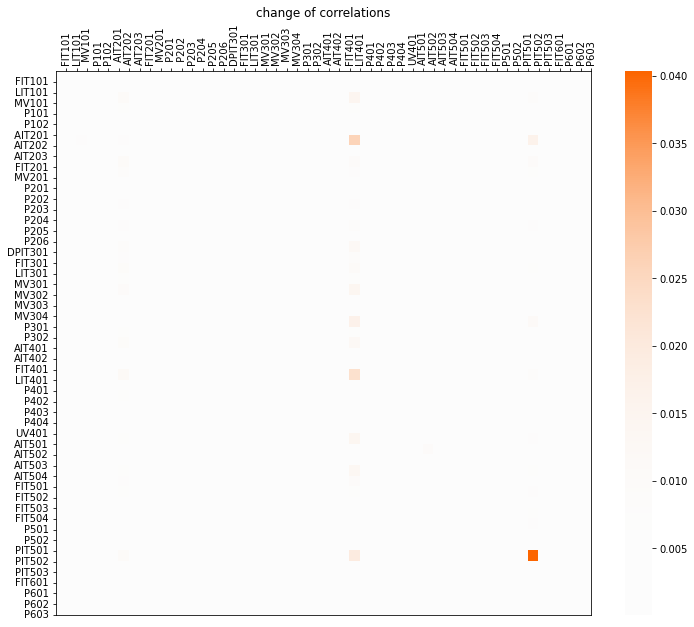

In [79]:
check_attn(nor_diff, columns)
plt.show()

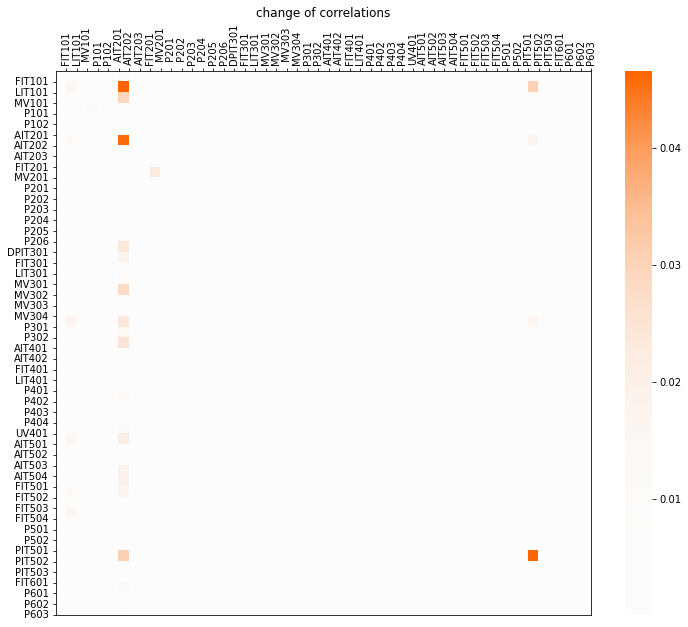

In [80]:
check_attn(abnor_diff, columns)
plt.show()

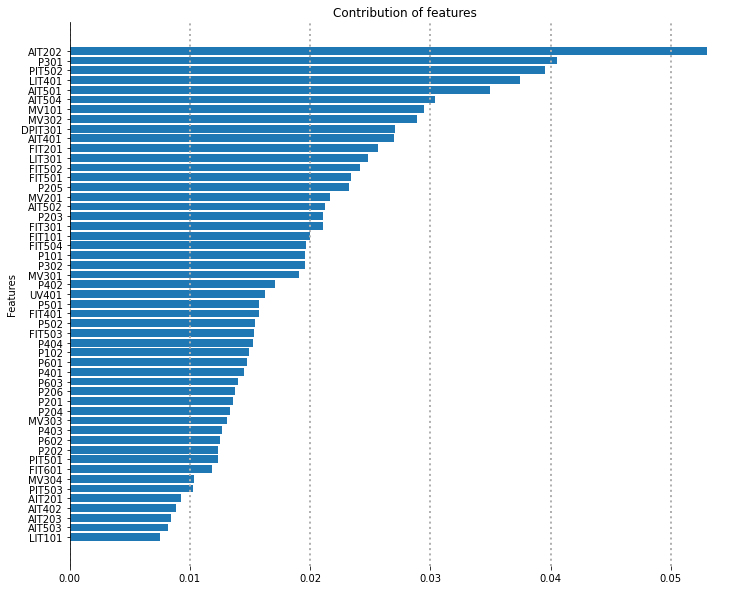

In [72]:
check_contribution(nor_diff, columns)
plt.show()

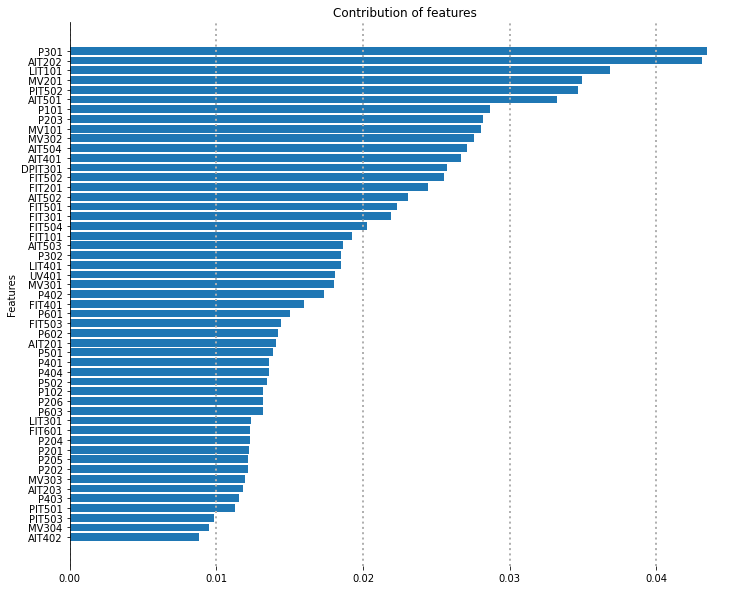

In [73]:
check_contribution(abnor_diff, columns)
plt.show()

---

### STEP 10. 명령어로 실행

```
python main.py \
--train \
--test \
--model VTTPAT \
--dataname SWaT \
--use_multi_gpu \
--devices 0,1
```

---